In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

In [18]:
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# === PATHS ===
train_dir =  r'E:\Dataset\Brain_Tumor_Classification\Training'
test_dir  = r'E:\Dataset\Brain_Tumor_Classification\Testing'
img_size  = (224, 224)   # same size you used in your model

# === Helper function ===
def load_dataset(data_dir, img_size):
    X, y = [], []
    classes = sorted(os.listdir(data_dir))
    for label in classes:
        class_path = os.path.join(data_dir, label)
        if not os.path.isdir(class_path):
            continue
        print(f"📂 Loading class: {label}")
        for file in tqdm(os.listdir(class_path), desc=f"{label}"):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, file)
                try:
                    img = load_img(img_path, target_size=img_size, color_mode='rgb')
                    img_array = img_to_array(img) / 255.0   # normalize 0–1
                    X.append(img_array)
                    y.append(label)
                except Exception as e:
                    print(f"⚠️ Skipped {img_path} due to error: {e}")
    return np.array(X, dtype=np.float32), np.array(y)

# === Load Train and Test sets ===
X_train, y_train = load_dataset(train_dir, img_size)
X_test,  y_test  = load_dataset(test_dir, img_size)

print(f"\n✅ X_train shape: {X_train.shape}")
print(f"✅ y_train shape: {y_train.shape}")
print(f"✅ X_test shape:  {X_test.shape}")


📂 Loading class: glioma_tumor


glioma_tumor: 100%|██████████| 826/826 [00:01<00:00, 504.44it/s]


📂 Loading class: meningioma_tumor


meningioma_tumor: 100%|██████████| 822/822 [00:01<00:00, 508.56it/s]


📂 Loading class: no_tumor


no_tumor: 100%|██████████| 395/395 [00:00<00:00, 654.98it/s]


📂 Loading class: pituitary_tumor


pituitary_tumor: 100%|██████████| 827/827 [00:01<00:00, 512.41it/s]


📂 Loading class: glioma_tumor


glioma_tumor: 100%|██████████| 100/100 [00:00<00:00, 315.31it/s]


📂 Loading class: meningioma_tumor


meningioma_tumor: 100%|██████████| 115/115 [00:00<00:00, 605.97it/s]


📂 Loading class: no_tumor


no_tumor: 100%|██████████| 105/105 [00:00<00:00, 1047.51it/s]


📂 Loading class: pituitary_tumor


pituitary_tumor: 100%|██████████| 74/74 [00:00<00:00, 273.54it/s]



✅ X_train shape: (2870, 224, 224, 3)
✅ y_train shape: (2870,)
✅ X_test shape:  (394, 224, 224, 3)


In [5]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test  = label_encoder.transform(y_test)

print("Classes found:", label_encoder.classes_)


Classes found: ['glioma_tumor' 'meningioma_tumor' 'no_tumor' 'pituitary_tumor']


In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Suppose your labels are in a numpy array: y_train
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))


In [7]:
import keras
print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  3.12.0


In [8]:
base_model = ResNet50(include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [9]:
## Compile the model ###

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Example settings (customize as needed)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Creating generators from numpy arrays
train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=32,
        class_mode='sparse') 
test_generator = test_datagen.flow_from_directory(
        test_dir,  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=32,
        class_mode='sparse') 


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [75]:
labels = label_encoder.classes_
le = LabelEncoder()
integer_labels = le.fit_transform(labels)
print(integer_labels)

[0 1 2 3]


In [22]:
model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    class_weight=class_weight_dict,
    shuffle=True
)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 701s 8s/step - accuracy: 0.9735 - loss: 0.0718 - val_accuracy: 0.7360 - val_loss: 1.7760
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1033s 12s/step - accuracy: 0.9836 - loss: 0.0580 - val_accuracy: 0.7640 - val_loss: 1.4234
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1215s 13s/step - accuracy: 0.9868 - loss: 0.0349 - val_accuracy: 0.7563 - val_loss: 1.6954
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 675s 8s/step - accuracy: 0.9892 - loss: 0.0325 - val_accuracy: 0.7640 - val_loss: 1.8080
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 713s 8s/step - accuracy: 0.9955 - loss: 0.0130 - val_accuracy: 0.7284 - val_loss: 2.2263
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 735s 8s/step - accuracy: 0.9895 - loss: 0.0263 - val_accuracy: 0.7310 - val_loss: 2.5624
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 701s 8s/step - accuracy: 0.9913 - loss: 0.0275 - val_accuracy: 0.7944 - val_loss: 1.6122
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 778s 9s/step - accuracy: 0.9906 - loss: 0.0200 - val_accuracy: 0.7614

In [24]:
model.evaluate(train_generator)

90/90 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.8965 - loss: 0.3100


[0.310011625289917, 0.8965156674385071]

(224, 224, 3)
glioma_tumor


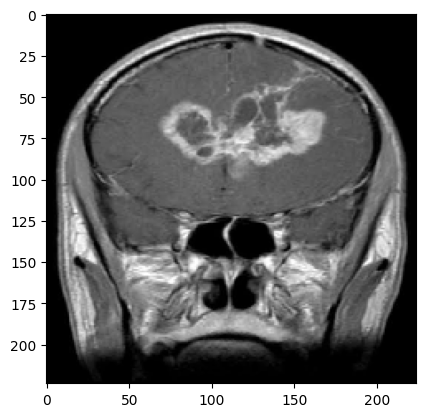

In [37]:
import matplotlib.pyplot as plt

img = X_test[0]

plt.imshow(img)
print(img.shape)
print(y_test[0])

In [39]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from keras.preprocessing.image import img_to_array

In [36]:
img_array = np.expand_dims(img, axis=0)
print(img_array.shape)
prediction = model.predict(img_array)
print(prediction)

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
[[8.5752070e-01 8.7076509e-03 1.3311522e-01 6.5646385e-04]]


In [53]:
# Initialize LimeImageExplainer
explainer = lime_image.LimeImageExplainer(kernel_width=0.15, random_state=42)

explanation = explainer.explain_instance(
    img, 
    model.predict, 
    labels=(0, ),
    hide_color=None, 
    top_labels=4, 
    num_features=1000, 
    num_samples=1000, 
    batch_size=10,
    segmentation_fn=None, 
    distance_metric='cosine', 
    model_regressor=None, 
    random_seed=10)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


  1%|          | 10/1000 [00:00<01:03, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  2%|▏         | 20/1000 [00:01<00:59, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


  3%|▎         | 30/1000 [00:01<01:00, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  4%|▍         | 40/1000 [00:02<01:00, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  5%|▌         | 50/1000 [00:03<00:59, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


  6%|▌         | 60/1000 [00:03<01:00, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


  7%|▋         | 70/1000 [00:04<01:01, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


  8%|▊         | 80/1000 [00:05<01:03, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  9%|▉         | 90/1000 [00:05<01:01, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 10%|█         | 100/1000 [00:06<01:00, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 11%|█         | 110/1000 [00:07<00:59, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 12%|█▏        | 120/1000 [00:07<00:57, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 13%|█▎        | 130/1000 [00:08<00:57, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 14%|█▍        | 140/1000 [00:09<00:56, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 15%|█▌        | 150/1000 [00:09<00:55, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 16%|█▌        | 160/1000 [00:10<00:54, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 17%|█▋        | 170/1000 [00:11<00:53, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 18%|█▊        | 180/1000 [00:11<00:52, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 19%|█▉        | 190/1000 [00:12<00:51, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 20%|██        | 200/1000 [00:12<00:50, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 21%|██        | 210/1000 [00:13<00:49, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 22%|██▏       | 220/1000 [00:14<00:50, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 23%|██▎       | 230/1000 [00:14<00:51, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 24%|██▍       | 240/1000 [00:15<00:50, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 25%|██▌       | 250/1000 [00:16<00:48, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 26%|██▌       | 260/1000 [00:16<00:48, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 27%|██▋       | 270/1000 [00:17<00:48, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 28%|██▊       | 280/1000 [00:18<00:48, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 29%|██▉       | 290/1000 [00:19<00:49, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 30%|███       | 300/1000 [00:19<00:48, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 31%|███       | 310/1000 [00:20<00:48, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 32%|███▏      | 320/1000 [00:21<00:46, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 33%|███▎      | 330/1000 [00:21<00:45, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 34%|███▍      | 340/1000 [00:22<00:44, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 35%|███▌      | 350/1000 [00:23<00:44, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 36%|███▌      | 360/1000 [00:23<00:45, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 37%|███▋      | 370/1000 [00:25<01:04,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 38%|███▊      | 380/1000 [00:26<00:57, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 39%|███▉      | 390/1000 [00:27<00:53, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 40%|████      | 400/1000 [00:27<00:50, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 41%|████      | 410/1000 [00:28<00:48, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 42%|████▏     | 420/1000 [00:29<00:47, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 43%|████▎     | 430/1000 [00:30<00:44, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 44%|████▍     | 440/1000 [00:30<00:41, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 45%|████▌     | 450/1000 [00:31<00:39, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 46%|████▌     | 460/1000 [00:32<00:39, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 47%|████▋     | 470/1000 [00:32<00:37, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 48%|████▊     | 480/1000 [00:33<00:36, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 49%|████▉     | 490/1000 [00:34<00:36, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 50%|█████     | 500/1000 [00:35<00:35, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 51%|█████     | 510/1000 [00:35<00:34, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 52%|█████▏    | 520/1000 [00:36<00:34, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 53%|█████▎    | 530/1000 [00:37<00:33, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 54%|█████▍    | 540/1000 [00:37<00:31, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 55%|█████▌    | 550/1000 [00:38<00:32, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 56%|█████▌    | 560/1000 [00:39<00:31, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 57%|█████▋    | 570/1000 [00:40<00:30, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 58%|█████▊    | 580/1000 [00:40<00:30, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 59%|█████▉    | 590/1000 [00:41<00:30, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 60%|██████    | 600/1000 [00:42<00:29, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 61%|██████    | 610/1000 [00:42<00:28, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 62%|██████▏   | 620/1000 [00:43<00:27, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 63%|██████▎   | 630/1000 [00:44<00:26, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 64%|██████▍   | 640/1000 [00:45<00:25, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 65%|██████▌   | 650/1000 [00:45<00:24, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 66%|██████▌   | 660/1000 [00:46<00:23, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 67%|██████▋   | 670/1000 [00:47<00:22, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 68%|██████▊   | 680/1000 [00:47<00:21, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 69%|██████▉   | 690/1000 [00:48<00:20, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 70%|███████   | 700/1000 [00:49<00:19, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 71%|███████   | 710/1000 [00:49<00:19, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 72%|███████▏  | 720/1000 [00:50<00:19, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 73%|███████▎  | 730/1000 [00:51<00:18, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 74%|███████▍  | 740/1000 [00:51<00:17, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 75%|███████▌  | 750/1000 [00:52<00:16, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 76%|███████▌  | 760/1000 [00:53<00:16, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 77%|███████▋  | 770/1000 [00:53<00:15, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 78%|███████▊  | 780/1000 [00:54<00:14, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 79%|███████▉  | 790/1000 [00:55<00:14, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 80%|████████  | 800/1000 [00:55<00:13, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 81%|████████  | 810/1000 [00:56<00:12, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 82%|████████▏ | 820/1000 [00:57<00:12, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 83%|████████▎ | 830/1000 [00:57<00:11, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 84%|████████▍ | 840/1000 [00:58<00:10, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 85%|████████▌ | 850/1000 [00:59<00:10, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 86%|████████▌ | 860/1000 [00:59<00:09, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 87%|████████▋ | 870/1000 [01:00<00:08, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 88%|████████▊ | 880/1000 [01:01<00:08, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 89%|████████▉ | 890/1000 [01:01<00:07, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 90%|█████████ | 900/1000 [01:02<00:06, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 91%|█████████ | 910/1000 [01:03<00:06, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 92%|█████████▏| 920/1000 [01:03<00:05, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 93%|█████████▎| 930/1000 [01:04<00:04, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 94%|█████████▍| 940/1000 [01:05<00:04, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 95%|█████████▌| 950/1000 [01:06<00:03, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 96%|█████████▌| 960/1000 [01:06<00:02, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 97%|█████████▋| 970/1000 [01:07<00:02, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 98%|█████████▊| 980/1000 [01:08<00:01, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 99%|█████████▉| 990/1000 [01:08<00:00, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


100%|██████████| 1000/1000 [01:09<00:00, 14.38it/s]


Text(0.5, 1.0, 'LIME Explanation')

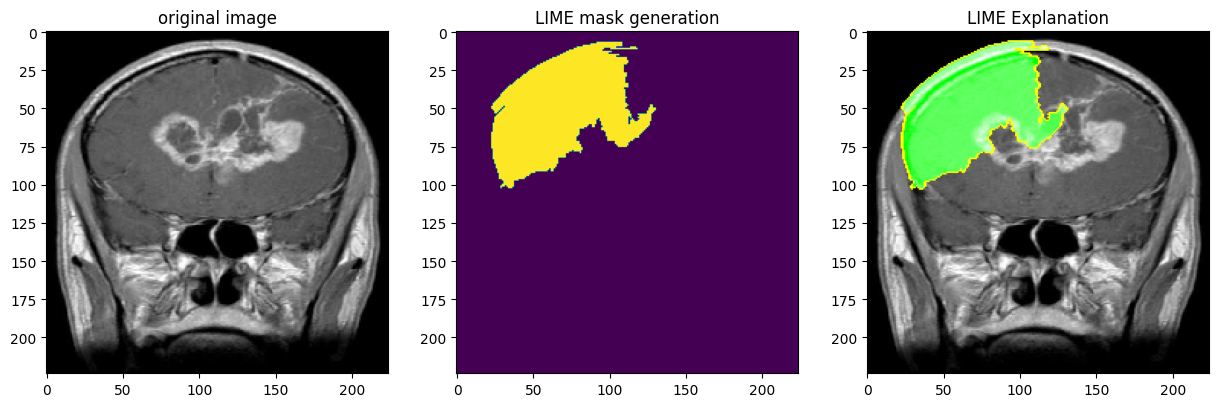

In [67]:
temp, mask = explanation.get_image_and_mask(
    label = explanation.top_labels[0],
    positive_only=False,
    hide_rest=False,
    num_features=5,
    min_weight=0.06
)

### Display the LIME Explanation ###
plt.figure(figsize=(15, 5)) 

plt.subplot(1,3,1)
plt.imshow(img)
plt.title('original image')

plt.subplot(1,3,2)
plt.imshow(mask)
plt.title('LIME mask generation')

plt.subplot(1,3,3)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")

In [77]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shap

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", X_train[0].shape)

# create an explainer with model and image masker
explainer_blur = shap.Explainer(model, masker_blur, output_names=label_encoder.classes_)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(X_test[0:1], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

PartitionExplainer explainer: 2it [06:09, 369.39s/it]              


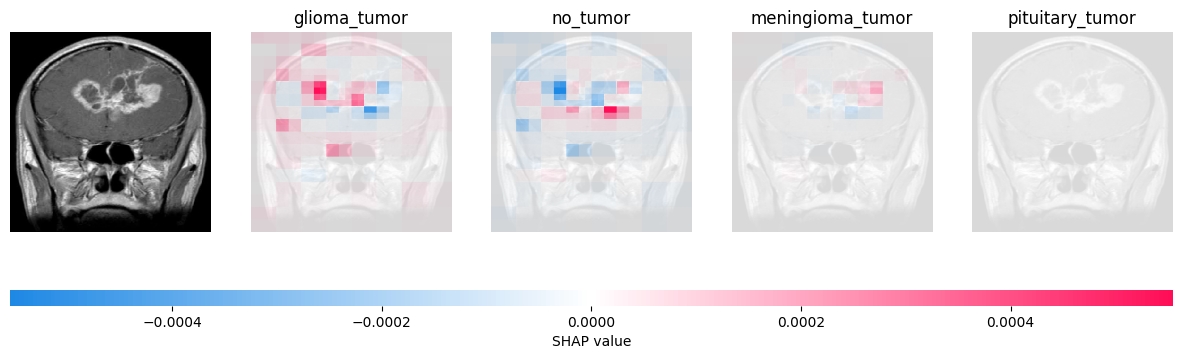

In [78]:
# output with shap values
shap.image_plot(shap_values_fine)